# Which brand should you consider first for a used car on eBay Kleinanzeigen?

Cars are well-known as having a high depreciation rate. Therefore, purchasing used car can usually be economically more favorable for many people. *eBay Kleinanzeigen* is a classfied advertising section of the German eBay website. Here I will work with [a dataset](https://www.kaggle.com/orgesleka/used-cars-database/data) which was orinigally scraped from *eBay Kleinanzeigen*, for the used car sell information. My goals are to:
- identify which brand should a customer consider first, based on the popularity and the price. 
- generate a predictive model using linear regression to predict the prices of used cars with most popular brands.

## Data Cleaning
The data cleaning involves two main stages:

The first stage is an overall dataset cleaning, where I will drop the unwanted data (such as missing data or data that is not useful for my analysis) and convert data into its correct type (e.g. convert string into float for numerical columns). 

The second stage is the cleaning for numerical columns, where I will remove outliers and redefine the boundaries of the numerical values in an rational way.

## Overall Dataset Cleaning

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
autos = pd.read_csv('autos.csv', encoding = 'Latin-1')

I start by exploring the head of the dataframe:

In [39]:
autos.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,odometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-26 17:47:46,Peugeot_807_160_NAVTECH_ON_BOARD,privat,Angebot,"$5,000",control,bus,2004,manuell,158,andere,"150,000km",3,lpg,peugeot,nein,2016-03-26 00:00:00,0,79588,2016-04-06 06:45:54
1,2016-04-04 13:38:56,BMW_740i_4_4_Liter_HAMANN_UMBAU_Mega_Optik,privat,Angebot,"$8,500",control,limousine,1997,automatik,286,7er,"150,000km",6,benzin,bmw,nein,2016-04-04 00:00:00,0,71034,2016-04-06 14:45:08
2,2016-03-26 18:57:24,Volkswagen_Golf_1.6_United,privat,Angebot,"$8,990",test,limousine,2009,manuell,102,golf,"70,000km",7,benzin,volkswagen,nein,2016-03-26 00:00:00,0,35394,2016-04-06 20:15:37
3,2016-03-12 16:58:10,Smart_smart_fortwo_coupe_softouch/F1/Klima/Pan...,privat,Angebot,"$4,350",control,kleinwagen,2007,automatik,71,fortwo,"70,000km",6,benzin,smart,nein,2016-03-12 00:00:00,0,33729,2016-03-15 03:16:28
4,2016-04-01 14:38:50,Ford_Focus_1_6_Benzin_TÜV_neu_ist_sehr_gepfleg...,privat,Angebot,"$1,350",test,kombi,2003,manuell,0,focus,"150,000km",7,benzin,ford,nein,2016-04-01 00:00:00,0,39218,2016-04-01 14:38:50


It can be noticed that the dataset uses camelcase in column name intead of the conventional snakecase in Python. To make my later analysis easier, I am going to change all the column names into snakecase.

In [40]:
# Change column names
autos.columns = ['date_crawled','name','seller','offer_type','price','abtest','vehicle_type','registration_year','gearbox','power_ps','model','odometer','registration_month','fuel_type','brand','unrepaired_damage','ad_created','n_of_pictures','postal_code','last_seen']

Based on my objective, the most related cloumns are *price, power_ps, odometer*, and *brand*. Other factors that may have significant impact on prices are:
- *registration_year*: it indirectly reflects the milage
- *seller*: private sellers may have lower price as compared to commercial sellers 
- *vehicle_type*: different vehicle type has different price
- *model*: different model has different price
- *unrepaired_damage*: cars with not repaired damage may have a significantly lower price

Other factors should not impact sell price a lot and thus can be removed.

In [41]:
autos = autos[['seller','price','power_ps','odometer','registration_year','brand','vehicle_type','model','unrepaired_damage']]

Let's take a look at the description of the new dataframe and see if it can be further simplified.

In [42]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
seller               50000 non-null object
price                50000 non-null object
power_ps             50000 non-null int64
odometer             50000 non-null object
registration_year    50000 non-null int64
brand                50000 non-null object
vehicle_type         44905 non-null object
model                47242 non-null object
unrepaired_damage    40171 non-null object
dtypes: int64(2), object(7)
memory usage: 3.4+ MB


In [43]:
autos.describe(include='all')

,seller,price,power_ps,odometer,registration_year,brand,vehicle_type,model,unrepaired_damage
count,50000,50000,50000.000000,50000,50000.000000,50000,44905,47242,40171
unique,2,2357,NaN,13,NaN,40,8,245,2
top,privat,$0,NaN,"150,000km",NaN,volkswagen,limousine,golf,nein
freq,49999,1421,NaN,32424,NaN,10687,12859,4024,35232
mean,NaN,NaN,116.355920,NaN,2005.073280,NaN,NaN,NaN,NaN
std,NaN,NaN,209.216627,NaN,105.712813,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,1000.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,70.000000,NaN,1999.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,105.000000,NaN,2003.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,150.000000,NaN,2008.000000,NaN,NaN,NaN,NaN


In [44]:
autos.unrepaired_damage.value_counts()

nein    35232
ja       4939
Name: unrepaired_damage, dtype: int64

Some interesting findings:
- *seller* column only have two unique values, and one of them have a frequency of 49999. This frequency is almost the same as the total count, and therefore analyzing this column may not give me any useful information. 
- *unrepaired_damage* column has almost all values being "nein" (which means "No" in German). The rest of the values are "ja" (which means "Yes"). Where the unrepaired damage happened and how serious the unrepaired damage was can significantly impact the price of the car. Considering that there is not enough information about the unrepaired damage, I will include only the cars that do not have unrepaired damage.

Selecting rows with only private seller and no unrepaired_damage can still give me enough data to build the model.

In [45]:
# Select only private seller and no unrepaired_damage, and remove the two columns
autos = autos.loc[(autos['seller']=='privat') & (autos['unrepaired_damage']=='nein'),:]
autos.drop(columns=['seller','unrepaired_damage'],inplace=True)

Since my goal is to determine how do power and milage impact price in three most common brands, I can remove *model* column as it is brand-specific. The vehicle type is also not in the scope of my analysis, so I will remove it too.

In [46]:
# Drop "model" and "vehicle_type" columns
autos.drop(columns=['model'], inplace=True)
autos.dropna(inplace=True)

The new dataframe is as follow.

In [47]:
autos.describe(include='all')

,price,power_ps,odometer,registration_year,brand,vehicle_type
count,33449,33449.000000,33449,33449.000000,33449,33449
unique,2161,NaN,13,NaN,40,8
top,"$1,500",NaN,"150,000km",NaN,volkswagen,limousine
freq,426,NaN,20132,NaN,6961,9702
mean,NaN,128.203683,NaN,2003.456366,NaN,NaN
std,NaN,199.720736,NaN,6.697639,NaN,NaN
min,NaN,0.000000,NaN,1931.000000,NaN,NaN
25%,NaN,77.000000,NaN,2000.000000,NaN,NaN
50%,NaN,116.000000,NaN,2004.000000,NaN,NaN
75%,NaN,156.000000,NaN,2008.000000,NaN,NaN


Notice that *price* and *odometer* columns are in "object" data type. I need to convert them into numerical type.

In [48]:
# Change the data type of columns "price" and "odometer" into float
autos['price'] = autos['price'].str.replace('$','')
autos['price'] = autos['price'].str.replace(',','')
autos['price'] = autos['price'].astype(float)


autos['odometer'] = autos['odometer'].str.replace('km','')
autos['odometer'] = autos['odometer'].str.replace(',','')
autos['odometer'] = autos['odometer'].astype(float)

# Rename the column titles to make them descriptive
autos.rename(columns={'price':'price_dollar', 'odometer':'odometer_km'},inplace=True)

In [49]:
autos['registration_year'] = autos['registration_year'].astype(float)
autos['power_ps'] = autos['power_ps'].astype(float)
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33449 entries, 0 to 49999
Data columns (total 6 columns):
price_dollar         33449 non-null float64
power_ps             33449 non-null float64
odometer_km          33449 non-null float64
registration_year    33449 non-null float64
brand                33449 non-null object
vehicle_type         33449 non-null object
dtypes: float64(4), object(2)
memory usage: 1.8+ MB


## Numerical Column Cleaning

### Price

Now, let's investigate columns *price_dollar* and *odometer_km* to see if additional cleaning is required. First, let's plot the *price_dollar* column.

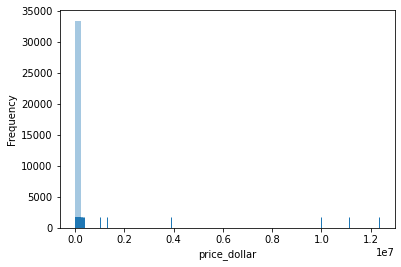

In [52]:
ax = sns.distplot(autos['price_dollar'], kde=False, rug=True)
ax.set_ylabel('Frequency')
plt.show()

The long thick bar indicates the frequency of the prices, while the short thin bars indicate where the prices locate at. As can be seen from the graph, majority of the prices fall below \\$100,000. However, several prices are way above \\$100,000 and caused the histogram compressed and we are unable to see any distribution from the graph. These large prices are likely outliers. Let's take a closer look at the statistics of the column:

In [53]:
autos['price_dollar'].describe()

count    3.344900e+04
mean     8.352164e+03
std      1.088783e+05
min      0.000000e+00
25%      1.798000e+03
50%      4.150000e+03
75%      9.000000e+03
max      1.234568e+07
Name: price_dollar, dtype: float64

It is noticed that the min price is 0 dollar, and the max price is 1,234,568 dollars. It is not normal to sell a car with a price of 0 dollar or higher than 500,000 dollars (the most luxurious cars in the world, like [Rolls Royce Phantom](https://www.rolls-roycemotorcars.com/en_GB/showroom/phantom.html) have price of 500,000 dollars. and the price is for brand new cars!). So, I need to set a proper price range for my analysis.

First, let's find the [interquartile range](https://en.wikipedia.org/wiki/Interquartile_range) (the difference between the third quartile and the first quartile). Based on the description above, the first quartile is 1,700 dollars, and the third quartile is 8,950 dollars.

In [54]:
# Find the interquartile range
interq_price = 8950 - 1700

The [major outliers](https://en.wikipedia.org/wiki/Outlier) are outside of the "outer fences". The upper bound of the "outer fences" is three interquartile range above the third quartile; the lower bound of the "outer fences" is three interquartile range below the first quartile.

In [55]:
# Find the outer fences
up_price = 8950 + 3 * interq_price
low_price = 1700 - 3 * interq_price
print("The upper bound is {num}".format(num=up_price))
print("The lower bound is {num}".format(num=low_price))

The upper bound is 30700
The lower bound is -20050


The lower bound of the "outer fences" does not make sense as it is a negative value. However, essentially it indicates that all values below the first quartile is not considered outlier. Still, based on the common sense, nobody should sell a call with 0 dollar. So I take all values between 0 dollar and 25500 dollars, excluding 0 dollar for my analysis.

In [56]:
autos = autos.loc[autos['price_dollar'].between(0.1, 30700)]

Let's see how the price distribution looks like now.

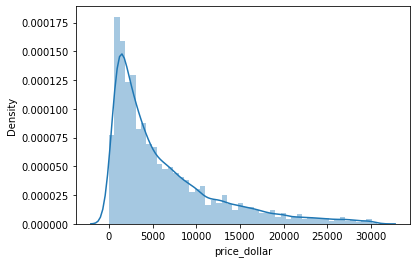

In [57]:
ax = sns.distplot(autos['price_dollar'])
ax.set_ylabel('Density')
plt.show()

The graph now looks much better as we can clearly see the distribution of the prices. Even though it is not perfectly normal distributed, it has been greatly improved.

### Odometer Reading

Now, let's examine the odometer_km column.

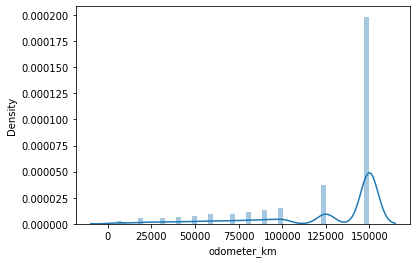

In [58]:
ax = sns.distplot(autos['odometer_km'])
ax.set_ylabel('Density')
plt.show()

The graph above tells us that the values in *odometer_km* column are discrete, with most of the values at around 150,000 km. As every car should have different odometer reading, the discontinuous odometer reading indicates that the values are recorded by estimations. For example, it is possible that all odometer readings that are between 125,000 km and 150,000 km are recorded as 125,000 km. What is more interesting, how come no car has odometer reading above 150,000 km? To figure out the reason, let's take a closer look at the column data.

In [28]:
autos['odometer_km'].describe()

count     32366.000000
mean     124141.691899
std       39400.852733
min        5000.000000
25%      100000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: odometer_km, dtype: float64

It is oberserved that the median value is equal to the max value, which means that over half of cars have odometer equal to 150,000 km. It is rare to see most of the cars having exactly the same odometer. I can think of two potential explainations: 
1. The cars with higher than 150,000 km are not included in the data set.
2. The odometers higher than 150,000 km are considered as 150,000 km.

In either way, considering that more than half of the data in this column is the same, this column may not be very useful for our analysis.

One alternative for odometer is the registration year. In general, the older the car, the higher the milage. So let's have a look at the *registration_year* column.

### Registration Year

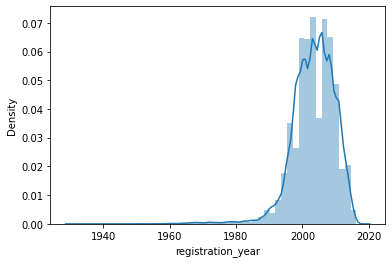

In [59]:
ax = sns.distplot(autos['registration_year'])
ax.set_ylabel('Density')
plt.show()

The graph looks great except for a very long and thin tail on the left side. This means that I got some outliers with small registration years. Let's take a closer look:

In [60]:
autos['registration_year'].describe()

count    32366.000000
mean      2003.390039
std          6.524744
min       1931.000000
25%       2000.000000
50%       2004.000000
75%       2008.000000
max       2018.000000
Name: registration_year, dtype: float64

It is noticed that the first quartile is at year 2000 but the minimum is at year 1931. This is a very large difference considering that the difference between the maximum and the first quartile is only 18 years. So I will use the "outer fences" to filter out the outliers.

In [61]:
# Filter out the outliers in "registration_year" column
interq_reg = 2008 - 2000
up_reg = 2008 + 3 * interq_reg
low_reg = 2000 - 3 * interq_reg
print("The upper bound is {num}".format(num=up_reg))
print("The lower bound is {num}".format(num=low_reg))

The upper bound is 2032
The lower bound is 1976


The lower bound found by "outer fences" method is reasonable. However, the upper bound is not. The maximum is year 2018 so I will use it as the upper bound instead.

In [63]:
autos = autos.loc[autos['registration_year'].between(1976,2019)]

Now let's look at our histogram for the registration year:

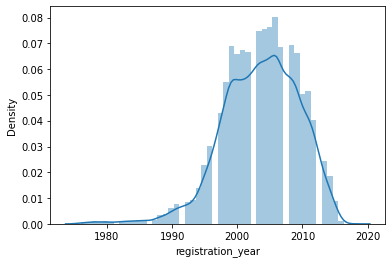

In [64]:
ax = sns.distplot(autos['registration_year'])
ax.set_ylabel('Density')
plt.show()

Much better!

### Power

Another parameter I need to fit into my model is the power of the car. So let's check *power_ps* column.

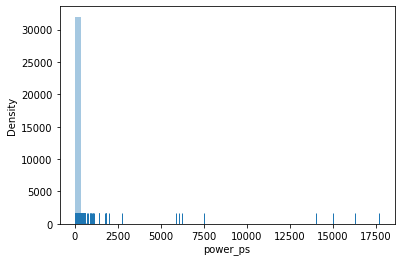

In [66]:
ax = sns.distplot(autos['power_ps'], kde=False, rug=True)
ax.set_ylabel('Density')
plt.show()

Again, similar to the price, we see a huge variation on power values. This is an indication for outliers. So let's take a closer look.

In [67]:
autos['power_ps'].describe()

count    32167.000000
mean       125.253738
std        201.306537
min          0.000000
25%         75.000000
50%        116.000000
75%        150.000000
max      17700.000000
Name: power_ps, dtype: float64

Apparently, a power of 17700 or 0 does not make sense. Again, let's use the "outer fences" method first to clean our data.

In [68]:
# Filter out the outliers in "power_ps" column
interq_power = 150 - 75
up_power = 150 + 3 * interq_power
low_power = 75 - 3 * interq_power
print("The upper bound is {num}".format(num=up_power))
print("The lower bound is {num}".format(num=low_power))

The upper bound is 375
The lower bound is -150


A negative power value cannot be used. So I need to find the lowest power value. Let's take a look at what low power values we have in the dataset:

In [69]:
autos['power_ps'].value_counts().sort_index(ascending=True).head(10)

0.0     1422
1.0        1
2.0        1
3.0        1
4.0        2
5.0       10
6.0        1
8.0        1
10.0       2
11.0       4
Name: power_ps, dtype: int64

Suprisingly, there are many cars with power less than 10. It's quite rare to see any cars with such low power today, so my first impression is that they are very old cars. Let's verify if it is truely the case.

In [70]:
autos.loc[autos['power_ps']==1]

,price_dollar,power_ps,odometer_km,registration_year,brand,vehicle_type
485,490.0,1.0,100000.0,2002.0,chrysler,limousine


The chart shows that a 2017 BMW has a power of 1 PS. This does not make sense as [the least powerful car](https://www.autoguide.com/auto-news/2017/07/top-10-cars-with-the-least-horsepower-in-2017.html) in 2017 that's available today has a power of 78 HP (79 PS). So I consider 79 PS as my lower bound for power. 

In [71]:
autos = autos.loc[autos['power_ps'].between(79,359)]

Now, the dataset is clean, and I can find the top three most famous brands for this data set. 

## Most Popular Brands

In [72]:
autos['brand'].value_counts().head(3)

volkswagen       4558
bmw              3617
mercedes_benz    3000
Name: brand, dtype: int64

**The top three brands are Volkswagen, BMW, Mercedes_benz.** 

## Model Building

Let's see if there are correlations between different variables to ensure no collinearity appears.

Let's use the data of the top three brands to build a linear regression model that predicts the prices of the used cars! First, since the vehicle types are categorical data, I convert them into one-hot form.

In [82]:
autos_one_hot = pd.get_dummies(autos, columns=['vehicle_type'])
autos_one_hot.drop(columns=['odometer_km'], inplace=True)

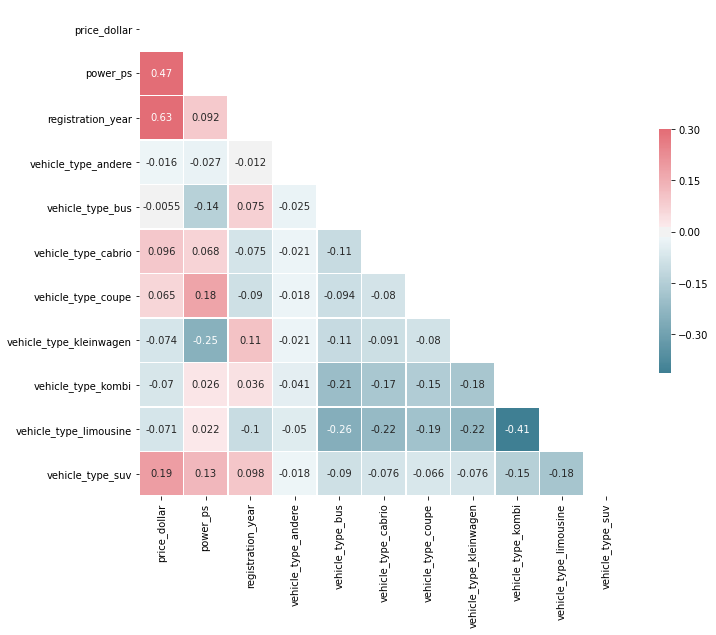

In [93]:
# Compute the correlation matrix
corr = autos_one_hot.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

As can be seen from the correlation map, power and registration year are strongly correlated with price. This means that I chose the right parameters for the prediction. Registration year and power also have correlations with vehicle types, especially power. This maakes sense as different vehicles are designed to have different power. For example, an SUV should have higher power than a supermini （kleinwagen). Since the correlations between vehicle types and power/registration year are below 0.2, I don't consider them as strongly correlated. Negative correlations between different vehicle types also make sense as they are unique.

Now let's start to build our model!

In [83]:
autos_vol = autos_one_hot.loc[autos['brand']=='volkswagen']
autos_bmw = autos_one_hot.loc[autos['brand']=='bmw']
autos_benz = autos_one_hot.loc[autos['brand']=='mercedes_benz']

In [85]:
autos_vol.drop(columns=['brand'], inplace=True)
autos_bmw.drop(columns=['brand'], inplace=True)
autos_benz.drop(columns=['brand'], inplace=True)

C:\Users\kuanw\anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The following code uses multiple regression model in sklearn to build the model. 

In [88]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

X1 = autos_vol.iloc[:,1:]
y1 = autos_vol.iloc[:,0]

X1= scale.fit_transform(X1.as_matrix())
X1 = sm.add_constant(X1)

est_vol = sm.OLS(y1, X1).fit()

est_vol.summary()

C:\Users\kuanw\anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_dollar   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     928.2
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:09:39   Log-Likelihood:                -43965.
No. Observations:                4558   AIC:                         8.795e+04
Df Residuals:                    4548   BIC:                         8.801e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8064.4974     55.456    145.422      0.000    7955.777    8173.218
x1          1658.3144     60.789     27.280      0.000    1539.137    1777.491
x2          4035.4376     57.829     69.782      0.000    3922.064    4148.811
x3           -42.2885     55.025     -0.769      0.442    -150.164      65.587
x4           545.4821     44.078     12.375      0.000     459.068     631.896
x5           552.5723     52.206     10.584      0.000     450.223     654.922
x6           241.8738     53.785      4.497      0.000     136.430     347.318
x7          -246.6333     51.612     -4.779      0.000    -347.818    -145.449
x8          -726.0038     42.310    -17.159      0.000    -808.953    -643.055
x9          -283.1997     39.403     -7.187      0.000    -360.448    -205.951
x10          628.3683     54.964     11.432      0.000     520.612     736.125
==============================================================================
Omnibus:                     1253.489   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4588.008
Skew:                           1.338   Prob(JB):                         0.00
Kurtosis:                       7.123   Cond. No.                     7.41e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.28e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [90]:
X2 = autos_bmw.iloc[:,1:]
y2 = autos_bmw.iloc[:,0]

X2 = scale.fit_transform(X2.as_matrix())
X2 = sm.add_constant(X2)

est_bmw = sm.OLS(y2, X2).fit()

est_bmw.summary()

C:\Users\kuanw\anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_dollar   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     772.7
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:10:34   Log-Likelihood:                -35008.
No. Observations:                3617   AIC:                         7.004e+04
Df Residuals:                    3607   BIC:                         7.010e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8440.9881     64.352    131.169      0.000    8314.818    8567.158
x1          2078.1322     67.641     30.723      0.000    1945.514    2210.750
x2          4366.0642     67.756     64.438      0.000    4233.221    4498.908
x3           -87.7350     64.163     -1.367      0.172    -213.533      38.063
x4            51.2599     64.318      0.797      0.426     -74.843     177.362
x5           926.5868     55.176     16.793      0.000     818.407    1034.766
x6           290.4591     55.746      5.210      0.000     181.163     399.755
x7           -74.4662     63.887     -1.166      0.244    -199.724      50.792
x8          -622.9828     47.788    -13.036      0.000    -716.678    -529.288
x9          -313.1394     40.612     -7.710      0.000    -392.765    -233.514
x10          313.5206     62.802      4.992      0.000     190.390     436.651
==============================================================================
Omnibus:                     1034.086   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4971.682
Skew:                           1.294   Prob(JB):                         0.00
Kurtosis:                       8.128   Cond. No.                     6.57e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.38e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [99]:
X3 = autos_benz.iloc[:,1:]
y3 = autos_benz.iloc[:, 0]

X3 = scale.fit_transform(X3.as_matrix())
X3 = sm.add_constant(X3)

est_benz = sm.OLS(y3, X3).fit()

est_benz.summary()

C:\Users\kuanw\anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_dollar   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     397.3
Date:                Fri, 04 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:26:03   Log-Likelihood:                -29692.
No. Observations:                3000   AIC:                         5.940e+04
Df Residuals:                    2990   BIC:                         5.946e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8412.8260     87.957     95.647      0.000    8240.364    8585.288
x1          2120.2896     98.686     21.485      0.000    1926.791    2313.789
x2          3959.3986     92.955     42.595      0.000    3777.137    4141.660
x3            -0.8225     87.640     -0.009      0.993    -172.664     171.019
x4           106.4217     82.100      1.296      0.195     -54.557     267.401
x5          1044.8354     80.525     12.975      0.000     886.946    1202.725
x6           -40.6304     78.627     -0.517      0.605    -194.798     113.538
x7          -293.5244     87.449     -3.357      0.001    -464.991    -122.057
x8          -711.0548     68.588    -10.367      0.000    -845.539    -576.571
x9          -278.0357     60.694     -4.581      0.000    -397.041    -159.030
x10          687.5095     84.141      8.171      0.000     522.529     852.490
==============================================================================
Omnibus:                      771.593   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1982.538
Skew:                           1.381   Prob(JB):                         0.00
Kurtosis:                       5.870   Cond. No.                     6.53e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.21e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Let's test our model by predicting prices for three brands' SUV with 120 PS and registration year of 2018:

In [100]:
car = [120, 2018, 0, 0, 0, 0, 0, 0, 0, 1]    # SUV with 120 PS and registration year of 2018
scaled = scale.transform([car])   # Standardization the values

scaled= sm.add_constant(scaled, has_constant='add')
predicted_vol = est_vol.predict(scaled)
predicted_bmw = est_bmw.predict(scaled)
predicted_benz = est_benz.predict(scaled)

print("The predicted price for Volkswagen is {num} dollars".format(num = int(predicted_vol)))
print("The predicted price for BMW is {num} dollars".format(num = int(predicted_bmw)))
print("The predicted price for Benz is {num} dollars".format(num = int(predicted_benz)))

The predicted price for Volkswagen is 19544 dollars
The predicted price for BMW is 19009 dollars
The predicted price for Benz is 19650 dollars


From the predictive model it can be found that:
- Both the registration year and the power have positive correlation with price.
- The registration year has larger impact on price as compared to the power.
- All three brands have similar model coefficients on registration year.
- Different vehicle types have very different impact on the prices.
- Volkswagen has a slightly lower base price, indicated by a lower constant coefficient
- Volkswagen has significantly lower coefficient value on the power. This means that the power does not impact the price of Volswagen used cars as much as BMW and Benz used cars.
- For a 2018 used SUV with 120 PS ([average car power](https://www.autolist.com/guides/average-car-horsepower)), the model predicts that BMW brand has the lowest price at 19009 dollars, Benz has the highest price at 19650 dollars. 